# Portfolio variance
This notebook shows how to compute the covariance and correlation matrices of a stock portfolio. Pandas Datareader is used to obtain daily prices over a specified timeframe. The correlation matrix is visualized in a heatmap, using the Seaborn library. Finally, the portfolio variance is computed and compared to that of the S&P 500.

Author: W.J.A. van Heeswijk
Date: 20-6-2021

## Import libraries

In [1]:
import datetime
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import seaborn as sns

## Define functions

In [2]:
def read_price_data(stock_symbol, start_date, end_date):
    """Read daily price data using Pandas Datareader"""
    stock_data = web.DataReader(stock_symbol, "yahoo", start_date, end_date) # Read stock data 
    prices = stock_data.loc[:, "Adj Close"] # Store adjusted close prices 
    prices = prices.fillna(method="ffill") # Forward fill missing data points

    return prices

In [3]:
def generate_return_series(prices):
    """Compute daily return series for given price series"""
    returns = np.zeros(len(prices) - 1)
    for i in range(len(prices) - 1):
        day_return = (prices[i + 1] - prices[i]) / prices[i]
        returns[i] = day_return

    return returns

## Set input

In [4]:
"""Set input"""
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2020, 1, 1)
symbol_list = ["AAPL", "AMZN", "FB", "GOOG", "MSFT"] #,"CAT", "NKE", "DAL","XOM"

num_stocks= len(symbol_list)
stock_weights = {stock_symbol:1/num_stocks for stock_symbol in symbol_list} # Set stock weights

price_series_sp500 = read_price_data("^GSPC", start_date, end_date) # Read price data
return_series_sp500 = generate_return_series(price_series_sp500) # Compute return data

no_business_days = len(return_series_sp500)
daily_returns = pd.DataFrame(index=symbol_list, columns=np.arange(no_business_days)) # Initialize DataFrame

## Read price data and compute return series

In [5]:
"""Read price data and compute daily returns"""
for stock_symbol in symbol_list:   
    price_series = read_price_data(stock_symbol, start_date, end_date) # Read price data
    return_series = generate_return_series(price_series) # Compute return data
    daily_returns.loc[stock_symbol] = return_series # Store return series in DataFrame
        
daily_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
AAPL,-0.099607,0.042689,-0.002226,0.019063,0.016982,0.003196,-0.009818,-0.015037,0.020467,0.012217,...,0.001965,-0.002390,0.001001,-0.002071,0.016318,0.000951,0.019840,-0.000380,0.005935,0.007307
AMZN,-0.025242,0.050064,0.034353,0.016612,0.001714,-0.001928,-0.009455,-0.014233,0.035462,0.005506,...,0.012124,-0.003703,0.004624,-0.003225,0.003638,-0.002114,0.044467,0.000551,-0.012253,0.000514
FB,-0.029039,0.047138,0.000725,0.032452,0.011927,-0.000208,-0.002774,0.011057,0.024486,-0.009466,...,0.002375,0.020717,0.017580,0.001165,-0.000582,-0.005141,0.013017,0.001492,-0.017732,0.004109
GOOG,-0.028484,0.053786,-0.002167,0.007385,-0.001505,-0.004029,-0.012277,-0.011824,0.031071,0.003546,...,-0.004445,-0.001845,0.002528,-0.004757,-0.000556,-0.003914,0.012534,-0.006256,-0.011650,0.000659
MSFT,-0.036788,0.046509,0.001275,0.007251,0.014299,-0.006425,-0.007722,-0.007296,0.029005,0.003523,...,-0.005401,-0.002069,0.008681,0.010918,0.000000,-0.000191,0.008197,0.001828,-0.008618,0.000698


## Compute covariance and correlation matrices

In [6]:
covariance_matrix = pd.DataFrame(index=symbol_list, columns=symbol_list)
correlation_matrix = pd.DataFrame(index=symbol_list, columns=symbol_list)

"""Compute all covariances and correlation coefficients"""
for stock1_symbol in symbol_list:
    for stock2_symbol in symbol_list:
        # Retrieve return series as arrays
        stock1_returns = daily_returns.loc[stock1_symbol].values.astype(float)
        stock2_returns = daily_returns.loc[stock2_symbol].values.astype(float)

        # Compute covariance
        cov = np.cov(stock1_returns, stock2_returns)[0][1]

        # Add covariance to matrix
        covariance_matrix.loc[stock1_symbol, stock2_symbol] = cov

        # Compute correlation
        corr = np.corrcoef(stock1_returns, stock2_returns)[0][1]

        # Add correlation to matrix
        correlation_matrix.loc[stock1_symbol, stock2_symbol] = corr

# Round correlation coefficients
correlation_matrix = correlation_matrix.astype(float).round(5)

correlation_matrix

,AAPL,AMZN,FB,GOOG,MSFT
AAPL,1.00000,0.59289,0.47580,0.55834,0.62190
AMZN,0.59289,1.00000,0.61667,0.60968,0.72312
FB,0.47580,0.61667,1.00000,0.56514,0.53147
GOOG,0.55834,0.60968,0.56514,1.00000,0.62918
MSFT,0.62190,0.72312,0.53147,0.62918,1.00000


## Plot heatmap correlation matrix

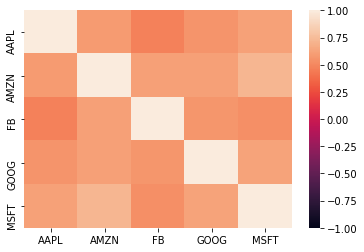

In [7]:
ax = sns.heatmap(correlation_matrix, vmin=-1, vmax=1)

## Compute portfolio variance
$\sigma_{P}^2=\sum_{i=1}^n \sum_{j=1}^n w_i w_j \sigma_{i,j}$

In [14]:
portfolio_mean = 0
portfolio_variance = 0

"""Compute mean portfolio return"""
for stock_symbol in symbol_list:
    
    # Retrieve return series as arrays
    stock_returns = daily_returns.loc[stock_symbol].values.astype(float)
    
    weight_stock = stock_weights.get(stock_symbol)

    mean_return = stock_returns.mean()
    portfolio_mean += mean_return *weight_stock

"""Compute variance portfolio return"""
for stock1_symbol in symbol_list:
    for stock2_symbol in symbol_list:
        weight_stock1 = stock_weights.get(stock1_symbol)
        weight_stock2 = stock_weights.get(stock2_symbol)
        covariance= covariance_matrix.loc[stock1_symbol,stock2_symbol]    
        portfolio_variance += weight_stock1*weight_stock2*covariance

# Compute annualized mean and volatility portfolio
ann_portfolio_mean = portfolio_mean*252
ann_portfolio_volatility = np.sqrt(252)*np.sqrt(portfolio_variance)

print('Annualized mean return:',"{0:.2%}".format(ann_portfolio_mean))
print('Annualized portfolio volatility:',"{0:.2%}".format(ann_portfolio_volatility))

Annualized mean return: 41.86%
Annualized portfolio volatility: 19.76%


## Compute mean and variance of S&P 500

In [22]:
# Compute annualized mean and volatility S&P 500
ann_sp500_mean = np.mean(return_series_sp500) *252
ann_SP500_volatility = np.sqrt(252) * np.std(return_series_sp500)

print('Annualized SP500 return:',"{0:.2%}".format(ann_sp500_mean))
print('Annualized SP500 volatility:',"{0:.2%}".format(ann_SP500_volatility))

Annualized SP500 return: 26.14%
Annualized SP500 volatility: 12.47%
